In [1]:
import matplotlib.pyplot as plt
import numpy as np

from timescales.sim import sim_lorentzian
from timescales.utils import resample_logspace
from timescales.plts import set_default_rc

import torch
from torch import nn
from torch.functional import F

set_default_rc()

In [2]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization. """
   
    def __init__(self, bounds, guess):
        
        super().__init__()
        
        # Initialize weights
        weights = torch.zeros(4)

        for ind in range(len(guess)):
            weights[ind] = torch.clamp(guess[ind], bounds[0][ind], bounds[1][ind])
            
        # Create torch parameters
        self.weights = nn.Parameter(weights)
        
    def forward(self, X):
        """Implement function to be optimised."""
        
        knee_freq, exponent, offset, constant = self.weights
        
        if knee_freq < 0:
            knee_freq = 0
        if exponent < 0:
            exopnent = 0
        
        return sim_lorentzian(X, knee_freq, exponent, offset, constant)
    
    
def training_loop(model, optimizer, x, y, n=1000):
    """Train model."""
    
    losses = []
    
    for i in range(n):
        preds = model(x)
        
        loss = F.mse_loss(preds, y).sqrt()
        loss.backward()
        

        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)  
        
    return losses

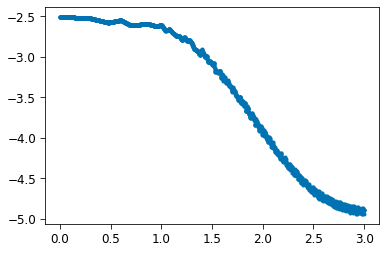

In [3]:
freqs = np.arange(1, 1001)

knee_freq = 20
exponent = 2
offset = 0
constant = 1e-5

powers = np.log10(sim_lorentzian(freqs, knee_freq, exponent, offset, constant))
powers += np.random.rand(len(powers)) * .1
powers = 10**powers 

freqs, powers = resample_logspace(freqs, powers, 2000)

freqs = np.log10(freqs)
powers = np.log10(powers)

freqs = torch.from_numpy(freqs).float()
powers = torch.from_numpy(powers).float()

plt.plot(freqs, powers, ls='', marker='.')

In [4]:
guess = torch.tensor([1, 2, 0, 0])

bounds = torch.tensor([
    [1,    1, -1, 0],
    [100,  4,  1, 1e-3]
])

model = Model(bounds, guess)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

losses = training_loop(
    model,
    opt,
    freqs,
    powers,
    n=2000
)

# Get prediction
preds = model(freqs)

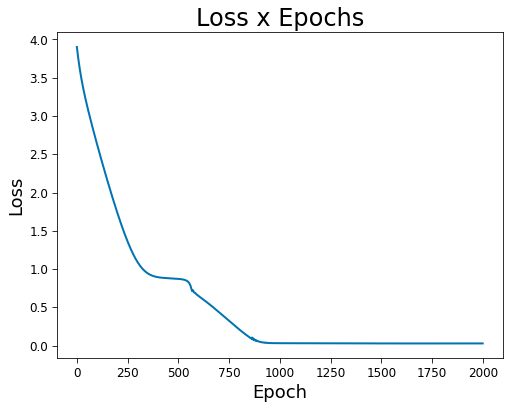

In [5]:
plt.figure(figsize=(8, 6))

plt.title('Loss x Epochs')
plt.plot([l.item() for l in losses])
plt.xlabel('Epoch')
plt.ylabel('Loss');

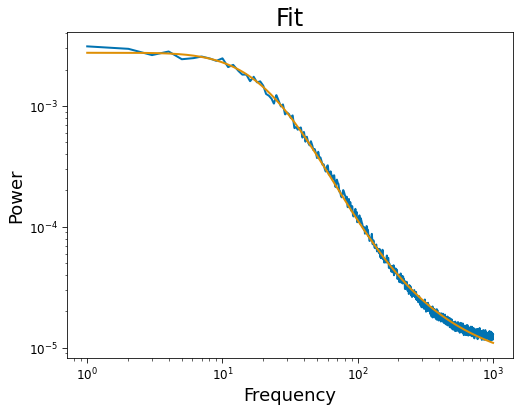

In [6]:
plt.figure(figsize=(8, 6))
plt.title('Fit')
plt.loglog(10**freqs, 10**powers, label='Simulated')
plt.loglog(10**freqs, 10**preds.detach().numpy(), label='Fit')
plt.xlabel('Frequency')
plt.ylabel('Power');